In [15]:
#from __future__ import absolute_import, division, print_function

import sys
import skimage.io
import numpy as np
import caffe
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../')
sys.path.append('../seg_model')

from seg_model import seg_model as segmodel
import otb_config
from util import processing_tools, im_processing, text_processing

from glob import glob, iglob
import xml.etree.ElementTree as ET

In [23]:
# Load config
config = otb_config.Config()

# Load the model
with open('./demo.prototxt', 'w') as f:
    f.write(str(segmodel.generate_model('val', config)))

caffe.set_device(config.gpu_id)
caffe.set_mode_gpu()

net = caffe.Net('./demo.prototxt', config.pretrained_model, caffe.TEST)

# Load vocabulary
vocab_dict = text_processing.load_vocab_dict_from_file(config.vocab_file)

In [24]:
# input image and query text
#im_file = './demo_data/38100.jpg'
#query = 'sky above the bridge'
k = 7
videofiles = sorted(glob('/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/*'))
videofile = videofiles[k]
video = videofile.split('/')[-1]
print(video)

start_frame = 1
if video == 'David':
    start_frame = 300
im_file = '/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/' + video + '/img/%04d.jpg' % (start_frame,)
query_file = '../OTB50/OTB50Entities/' + video + '.xml'

# Firstly, select query
root = ET.parse(query_file).getroot()
# querier = prettify( querier )
print(root[3][1].text)
query = root[3][1].text

# Secondly, get gt box
gt_file = '/home/zhenyang/Workspace/data/Tracker_Benchmark_v1.0/' + video + '/groundtruth_rect.txt'
try:
    gt_boxes = np.loadtxt(gt_file, delimiter=',').astype(int)
except ValueError:
    gt_boxes = np.loadtxt(gt_file, delimiter='\t').astype(int)
gt_box = gt_boxes[0, :]
gt_box[2] = gt_box[0] + gt_box[2] - 1;
gt_box[3] = gt_box[1] + gt_box[3] - 1;

# ###
# Run on the input image and query text
text_seq_val = np.zeros((config.T, config.N), dtype=np.float32)
imcrop_val = np.zeros((config.N, config.input_H, config.input_W, 3), dtype=np.float32)

# Preprocess image and text
im = skimage.io.imread(im_file)
processed_im = skimage.img_as_ubyte(im_processing.resize_and_pad(im, config.input_H, config.input_W))
if processed_im.ndim == 2:
    processed_im = np.tile(processed_im[:, :, np.newaxis], (1, 1, 3))
imcrop_val[0, :] = processed_im.astype(np.float32) - segmodel.channel_mean
imcrop_val = imcrop_val.transpose((0, 3, 1, 2))
imcrop_val = imcrop_val[:, ::-1, :, :]

spatial_val = processing_tools.generate_spatial_batch(config.N, config.featmap_H, config.featmap_W)
spatial_val = spatial_val.transpose((0, 3, 1, 2))

text_seq_val[:, 0] = text_processing.preprocess_sentence(query, vocab_dict, config.T)
cont_val = text_processing.create_cont(text_seq_val)

dummy_label = np.zeros((config.N, 1, config.input_H, config.input_W), dtype=np.float32)

# Forward pass to get response map
net.blobs['language'].data[...] = text_seq_val
net.blobs['cont'].data[...] = cont_val
net.blobs['image'].data[...] = imcrop_val
net.blobs['spatial'].data[...] = spatial_val
net.blobs['label'].data[...] = dummy_label

net.forward()

upscores = net.blobs['upscores'].data[...].copy()
upscores = np.squeeze(upscores)

# Final prediction
prediction = im_processing.resize_and_crop(upscores>0, *im.shape[:2]).astype(np.bool)


Couple
two people walking on the left


query text = 'two people walking on the left'


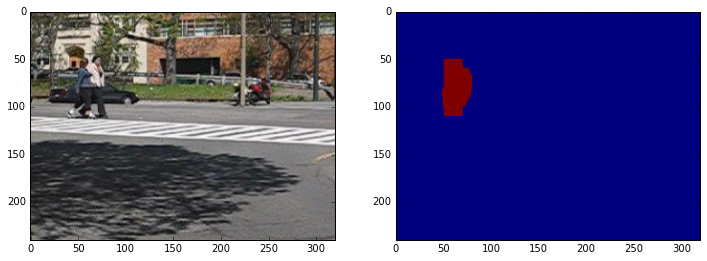

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(prediction)

print("query text = '%s'" % query)